# Niwot Species Distribution Models
### Aaron Westmoreland, Michael Catchen, Will Reed(?)
---


## I. Introduction

- What did we do (multilevel species dist models) 
- What data do we have (a lot)
- What questions did we answer (none to very few)
- How did we do/not do it (stan)
- What big words can we look forward to hearing in the next 20 minutes? (Bayesian multilevel models, Hamiltonian Monte Carlo)
- Can we say anything about the world based on this analysis? (kinda)
- Can we predict anything about the world based on this analysis? (fat chance, buster)

### Dependencies

#### Load Libraries

In [1]:
# run devtools::install_github("rmcelreath/rethinking") from rstudio
reqs = c("tidyverse", "Rcpp", "rstan", "mvtnorm", "extraDistr","rethinking", "coda","mvtnorm","devtools","loo","dagitty","GGally","rethinking")
lapply(reqs, require, character.only=T)

Loading required package: tidyverse

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: Rcpp

Loading required package: rstan

Loading required package: StanHeaders

rstan (Version 2.19.3, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: mvtnorm

Loading required package: extraDistr


Attaching package: ‘extraDi

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

#### Load Helper Functions

In [24]:
source('./src/helper_functions.R');
source('./src/simulate_data.R');

## II. The Data

### 2.1 Load Data

In [6]:
presence_absence_data = read.csv('./data.csv')
# standardize environmental vars
presence_absence_data[,10:ncol(presence_absence_data)] = standardize(presence_absence_data[,10:ncol(presence_absence_data)] )
presence_absence_data$time = presence_absence_data$year - 2018
presence_absence_data$subplot = presence_absence_data$mid_sub
precis(presence_absence_data)
n_plots =  length(unique(presence_absence_data$plot))

,mean,sd,5.5%,94.5%,histogram
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
X,3.635000e+02,209.7224356,4.087500e+01,6.861250e+02,▇▇▇▇▇▇▇▂
Easting,4.515599e+05,1194.3055213,4.493850e+05,4.536260e+05,▂▁▇▁▇▃▇▂▃▂
Northing,4.433183e+06,812.2656754,4.431776e+06,4.434395e+06,▂▇▅▅▇▇▁
PA,3.870523e-01,0.4874116,0.000000e+00,1.000000e+00,▇▁▁▁▁▁▁▁▁▅
plot,NaN,NA,NA,NA,
top_sub,3.600000e+01,4.4853785,3.100000e+01,4.100000e+01,▇▁▁▁▁▁▁▁▃▃
mid_sub,3.625000e+01,4.4781423,3.110000e+01,4.140000e+01,▇▇▁▁▁▁▁▁▁▇▇
middle,2.500000e+00,1.3064825,1.000000e+00,4.000000e+00,▇▂▁▂▁▇
year,2.017909e+03,0.7930735,2.017000e+03,2.019000e+03,▇▁▁▁▇▁▁▁▁▅


### 2.2 Data Exploration

#### Plot Structure

The are Niwot saddle plots. Here we plot them in 2d space.

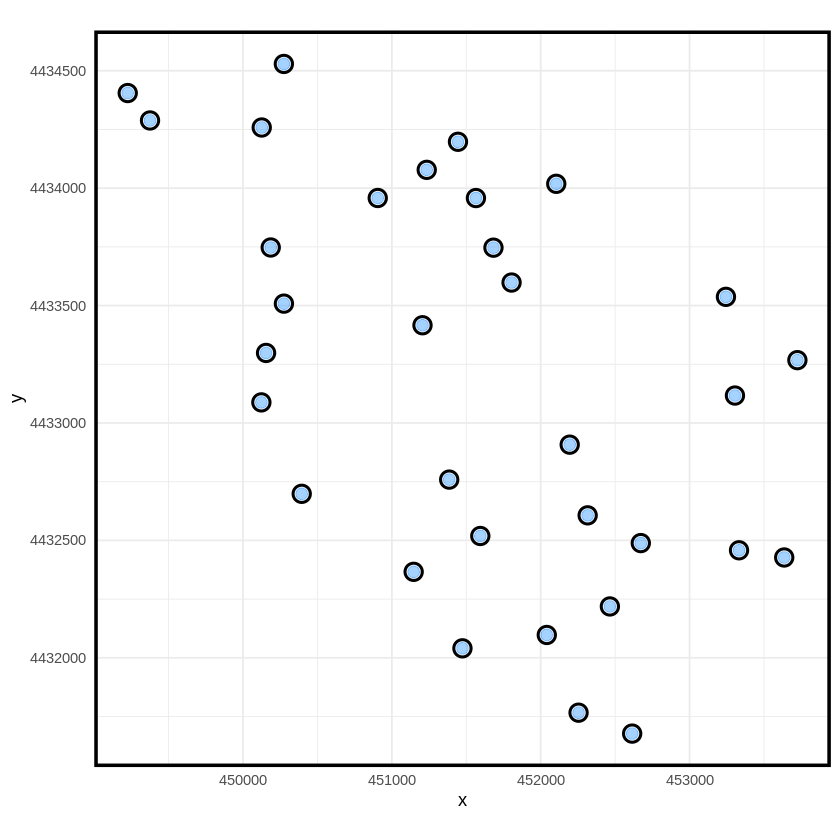

In [7]:
presence_absence_data %>% 
    group_by(plot) %>% 
    summarize(x=mean(Easting), y=mean(Northing)) %>% 
    ggplot(aes(x, y)) + 
        geom_point(size=3,alpha=0.4, color='dodgerblue') +
        geom_point(size=4,stroke=1.3,shape=1) + 
        theme_minimal() + 
        theme(aspect.ratio=1, panel.border=element_rect(fill=NA,size=2))

#### Environmental Variables

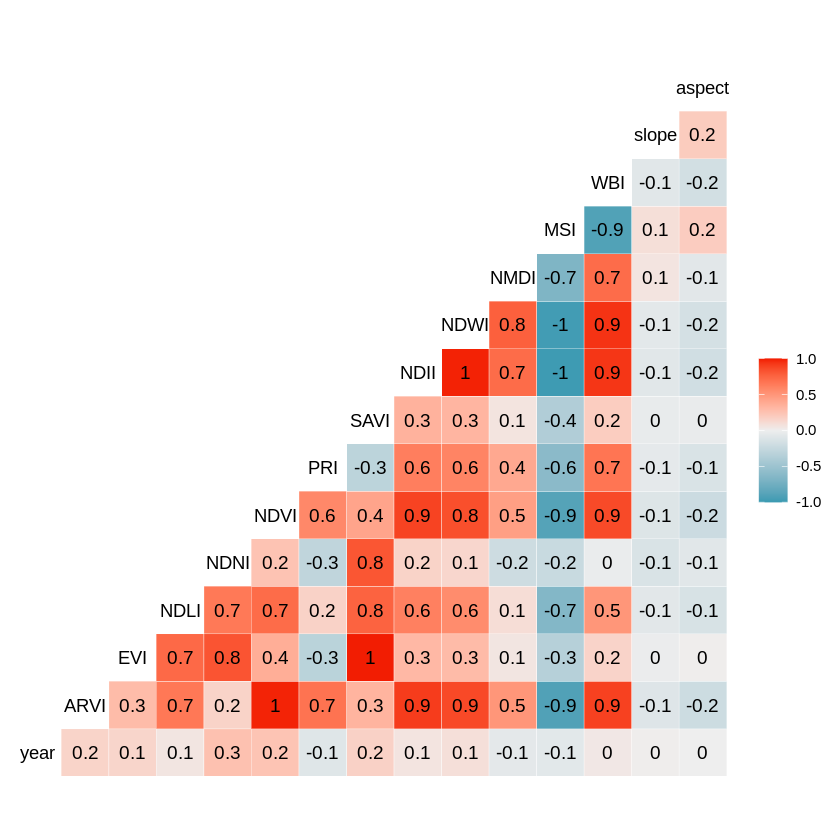

In [66]:
ggcorr(presence_absence_data[,11:ncol(presence_absence_data)-2], label=T)

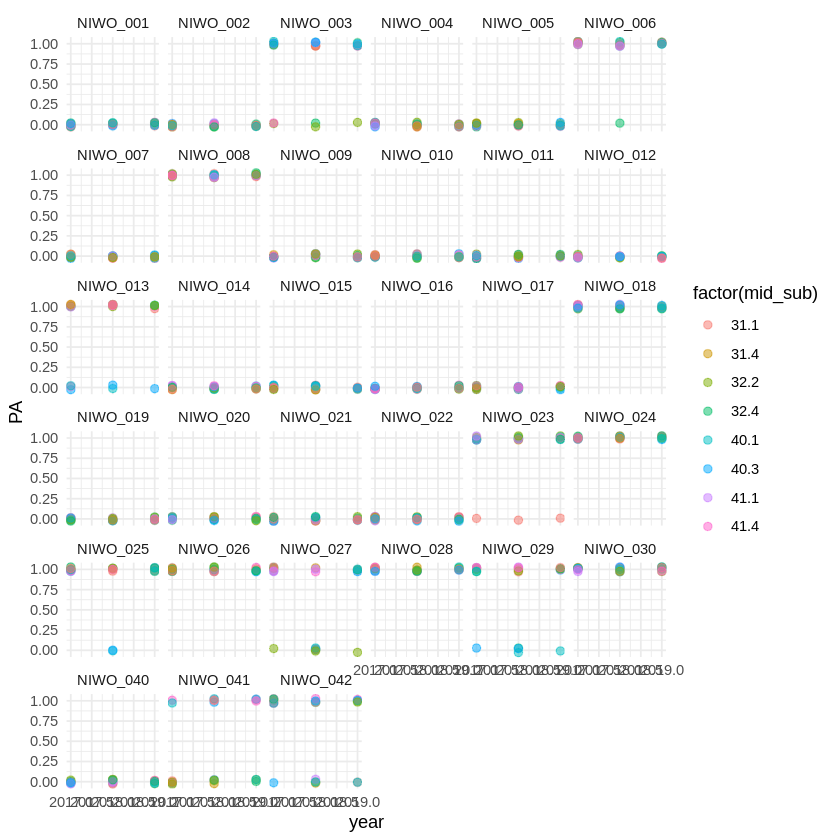

In [7]:
presence_absence_data %>%
    group_by(plot, year) %>%
    ggplot(aes(year, PA, color=factor(mid_sub))) + 
    geom_jitter(height=0.03,width=0, size=2, alpha=0.5) + 
    facet_wrap(. ~ plot) + 
    theme_minimal() 

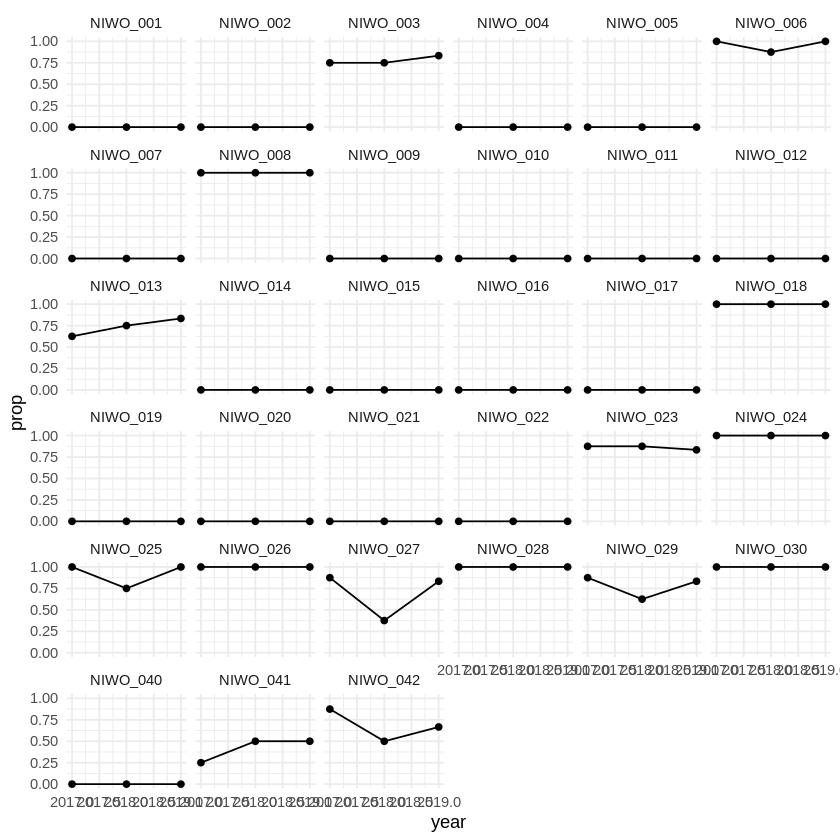

In [8]:
presence_absence_data %>% 
    group_by(plot, year) %>%
    summarize(prop=sum(PA)/length(PA)) %>%
    ggplot(aes(year, prop)) + geom_line() + geom_point() + facet_wrap(. ~ plot) + theme_minimal() + ylim(0,1)

## III. Models

### 3.1 Total Pooling, No Effects

- Total pooling, intercept only, no predictors
- effectively the same as logistic regression of PA with no predictors

$$S_i \sim Bernoulli(p_i) \quad\quad \text{likelihood}$$

$$\text{logit}(p_i) = \alpha \quad\quad \text{link}$$

$$\alpha \sim \text{N}(0,0.5)$$

In [8]:
model3.1 = map2stan(
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a,
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
model3.1
model3.1_posterior = data.frame(extract.samples(model3.1))


SAMPLING FOR MODEL '92b441b9af666595bc63df91a6300a67' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 9.1e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.91 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.415119 seconds (Warm-up)
Chain 1:                0.327284 seconds (Sampling)


Computing WAIC



map2stan model
1000 samples from 1 chain

Sampling durations (seconds):
        warmup sample total
chain:1   0.42   0.33  0.74

Formula:
PA ~ dbinom(1, p)
logit(p) <- a
a ~ dnorm(0, 5)

WAIC (SE): 952 (11.2)
pWAIC: 0.91 

#### 3.1.1 Model Visualization

In [6]:
model3.1_posterior$p = exp(model3.1_posterior$a) / (exp(model3.1_posterior$a) + 1)
model3.1_posterior$sigma = n_plots * model3.1_posterior$p * (1-model3.1_posterior$p) 

In [10]:
distribution_posterior = data.frame(matrix(ncol=3))
colnames(distribution_posterior) = c("x", "pr_x", "sample")
interval = rep(seq(0,33,by=0.1), n_plots)
r = 1

n_samples = length(model3.1_posterior$a)
for (r in 1:5){
    p_hat = rep(model3.1_posterior[r,]$p, length(interval))
    sigma_hat = rep(model3.1_posterior[r,]$sigma, length(interval))
    pr_x = exp((-1*(interval-p_hat)^2)/sigma_hat^2)  
    
    this_df = data.frame(x=interval, pr_x=pr_x, sample=rep(r, length(interval)))
    
    distribution_posterior = rbind(distribution_posterior, this_df)
}
#pr_x = exp((-1*(interval-model3.1_posterior$p)^2)/model3.1_posterior$sigma^2)

x,pr_x,sample
<dbl>,<dbl>,<int>
NA,NA,NA
0.0,0.9975059,1
0.1,0.9986115,1
0.2,0.9993960,1
0.3,0.9998588,1
0.4,0.9999993,1
0.5,0.9998175,1
0.6,0.9993135,1
0.7,0.9984879,1


### 3.2 Total Pooling, Indepedent Effects

The dang ol' linear model. 

$$S_i \sim Bernoulli(p_i)  \quad\quad\quad\quad \text{likelihood}$$ 

$$p_i = \text{logit}(\alpha_i + \sum_j \beta_j x_{ij}) \quad\quad\quad\quad \text{link} $$

$$\alpha \sim N(0, 5) \quad\quad\quad\quad\text{intercept prior}$$ 

In [61]:
model3.2 = ulam(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*time 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_NDWI*NDWI
                    + beta_EVI*EVI
                    + beta_ARVI*ARVI
                    + beta_aspect*aspect
                    + beta_slope*slope,
        beta_time ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        beta_EVI ~ dnorm(0,5),
        beta_ARVI ~ dnorm(0,5),
        beta_aspect ~ dnorm(0,5),
        beta_slope ~ dnorm(0,5),
        a ~ dnorm( 0, 5 )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(model3.2)

Removing one or more character or factor variables:

plot




SAMPLING FOR MODEL '324f47f325978f1571c7752fdf36c125' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000343 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.43 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:   1 / 1000 [  0%]  (Warmup)
Chain 1: Iteration: 100 / 1000 [ 10%]  (Warmup)
Chain 1: Iteration: 200 / 1000 [ 20%]  (Warmup)
Chain 1: Iteration: 300 / 1000 [ 30%]  (Warmup)
Chain 1: Iteration: 400 / 1000 [ 40%]  (Warmup)
Chain 1: Iteration: 500 / 1000 [ 50%]  (Warmup)
Chain 1: Iteration: 501 / 1000 [ 50%]  (Sampling)
Chain 1: Iteration: 600 / 1000 [ 60%]  (Sampling)
Chain 1: Iteration: 700 / 1000 [ 70%]  (Sampling)
Chain 1: Iteration: 800 / 1000 [ 80%]  (Sampling)
Chain 1: Iteration: 900 / 1000 [ 90%]  (Sampling)
Chain 1: Iteration: 1000 / 1000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.48878 seconds (Warm-up)
Chain 1:                2.85465 seconds (Sampling)
Chain 1:    

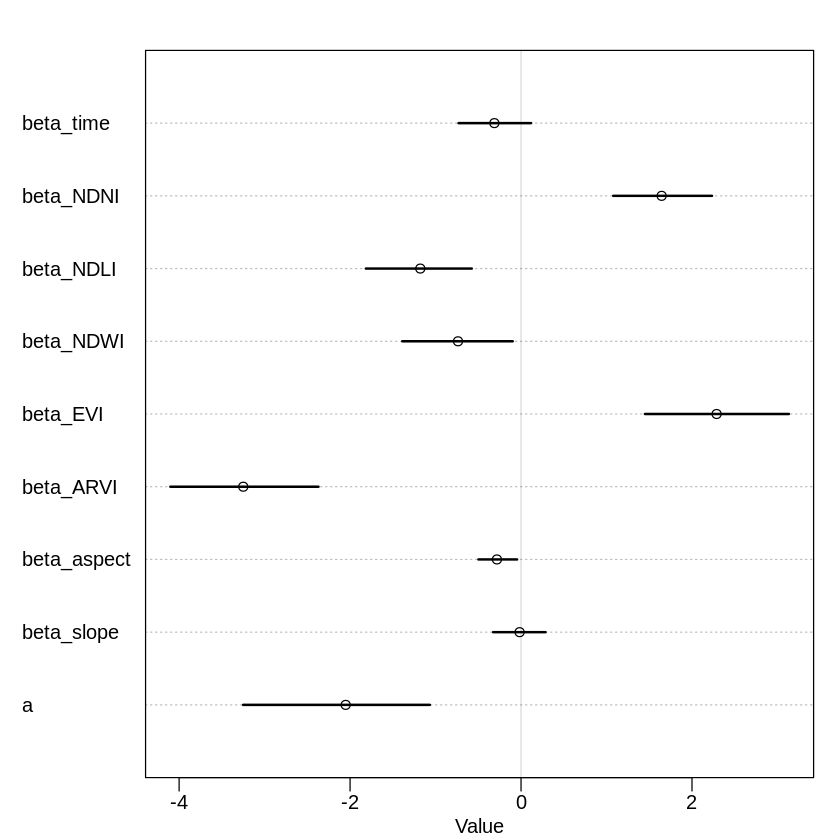

In [64]:
plot(precis(model3.2,depth=2)) # also plot

#### Varying Intercepts

$$S_i \sim Bernoulli(p_i)  \quad\quad\quad\quad\quad\quad \text{likelihood}$$ 

$$p_i = \text{logit}(\alpha_i + \sum_j \beta_j x_{ij}) \quad\quad\quad\quad\quad\quad \text{link} $$

$$\alpha_i \sim N(\mu_\alpha, \sigma_\alpha) \quad\quad\quad\quad\quad\quad \text{intercept prior}$$ 

$$\mu_\alpha \sim  N(0, 5)  \quad\quad\quad\quad  \text{hyperprior for mean intercept} $$

$$\sigma^2_\alpha \sim  \text{Exp}(1)  \quad\quad  \text{hyperprior for intercept variance} $$

In [4]:
varying_intercepts = map2stan(
    # model definition
    alist(
        PA ~ dbinom(1, p),
        logit(p) <- a 
                    + beta_time*year 
                    + beta_NDNI*NDNI 
                    + beta_NDLI*NDLI 
                    + beta_NDWI*NDWI
                    + beta_EVI*EVI
                    + beta_ARVI*ARVI,
        beta_time ~ dnorm(0,5),
        beta_NDNI ~ dnorm(0,5),
        beta_NDLI ~ dnorm(0,5),
        beta_NDWI ~ dnorm(0,5),
        beta_EVI ~ dnorm(0,5),
        beta_ARVI ~ dnorm(0,5),
        a_mean ~ dnorm(0,1),
        a_var ~ dexp(1),
        a[plot] ~ dnorm( a_mean, a_var )
    ),
    data=na.omit(presence_absence_data))
post = extract.samples(varying_intercepts)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL 'f3d8f002800c25b9ca76c6d4bd2a1e8e' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.00046 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 4.6 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 93.7952 seconds (Warm-up)
Chain 1:                36.9954 seconds (Sampling)
Cha

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Computing WAIC



Here is the 95% interval for the posterior of each parameter 

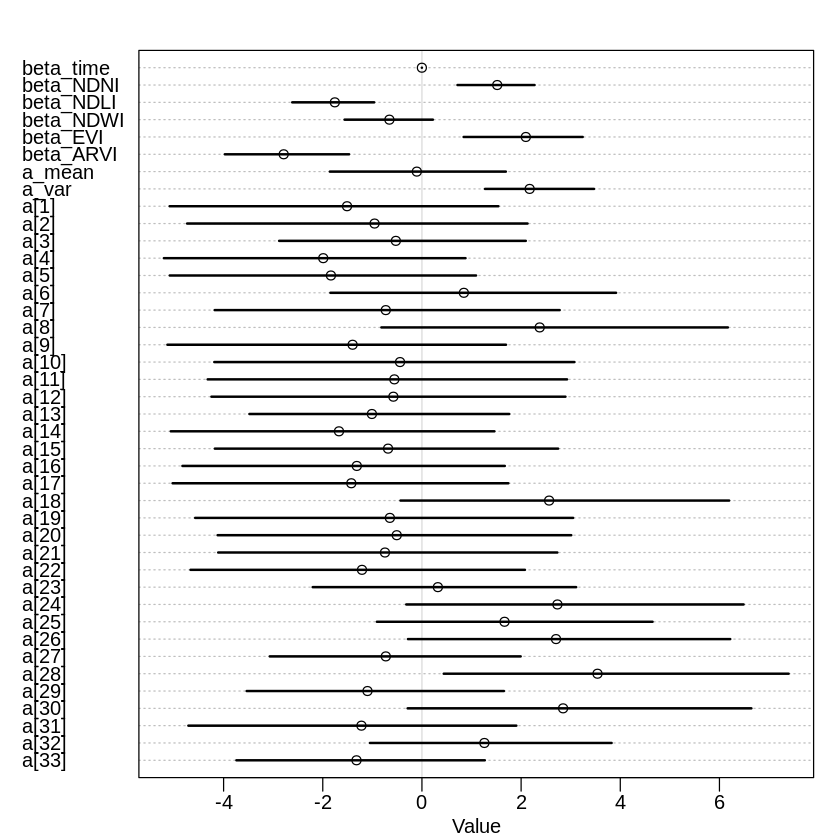

In [5]:
plot(precis(varying_intercepts,width=0.95,depth=2)) # also plot

### lets try this _without_ standardizing environmental indecies

In [25]:
no_stdization_presence_absence_data = read.csv('data.csv')
varying_intercepts_without_standardization = run_best_model(no_stdization_presence_absence_data)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL '9c61d79aeb06d5d7da8b49979f5e7cb3' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000387 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.87 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 10.282 seconds (Warm-up)
Chain 1:                6.62673 seconds (Sampling)
Ch

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Computing WAIC



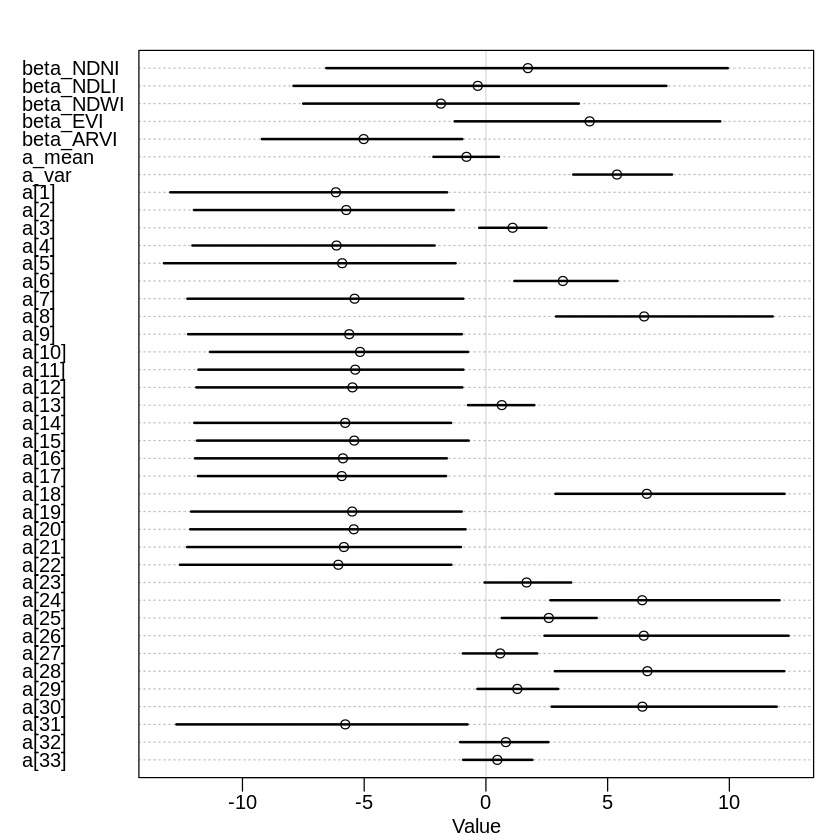

In [15]:
plot(precis(varying_intercepts_without_standardization,width=0.95,depth=2)) # also plot

In [26]:
## Plot occurance probs now/ with this model

## III. "forecasting"

- not a lot of temporal variance

In [22]:
geum_17 = presence_absence_data %>% filter(year==2017)
geum_17_and_18 = presence_absence_data %>% filter(year==2017, year == 2018)
geum_18 = presence_absence_data %>% filter(year==2018)
geum_19 = presence_absence_data %>% filter(year==2019)


### train on 2017 only, and predict 2018.

In [20]:
model_2017 = run_best_model(geum_17)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL 'd26cf0b96c3b480db1621aadf700706a' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000171 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 1.71 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 3.65786 seconds (Warm-up)
Chain 1:                2.49975 seconds (Sampling)
C

Warning message:
“There were 2 divergent transitions after warmup. Increasing adapt_delta above 0.95 may help. See
http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup”
Warning message:
“There were 1 chains where the estimated Bayesian Fraction of Missing Information was low. See
http://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”
Computing WAIC

Warning message in map2stan(alist(PA ~ dbinom(1, p), logit(p) <- a + beta_NDNI * :
“There were 2 diverg

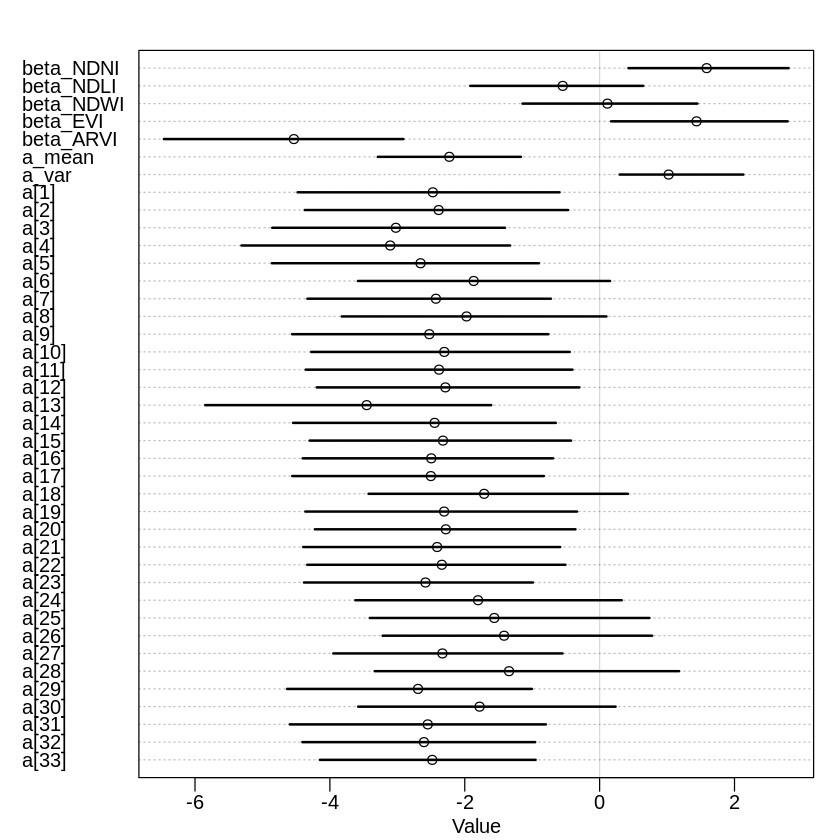

In [27]:
plot(precis(model_2017,width=0.95,depth=2)) # also plot

### how well does this model predict occupancy in 2018 and 2019?

### train on 2017 and 2018, predict 2019
- does more temporal data help?
- power analysis on how many timesteps do you need to detect temporal variability?

In [28]:
model_17_and_18 = run_best_model(geum_17_and_18)

Warning message in coerce_index(d[[xvp$group]]):
“NAs introduced by coercion”



SAMPLING FOR MODEL '0f9eac757f7efe3c9386e2b5aa7d4f7c' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.000374 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 3.74 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 9.60538 seconds (Warm-up)
Chain 1:                7.20931 seconds (Sampling)
C

Computing WAIC



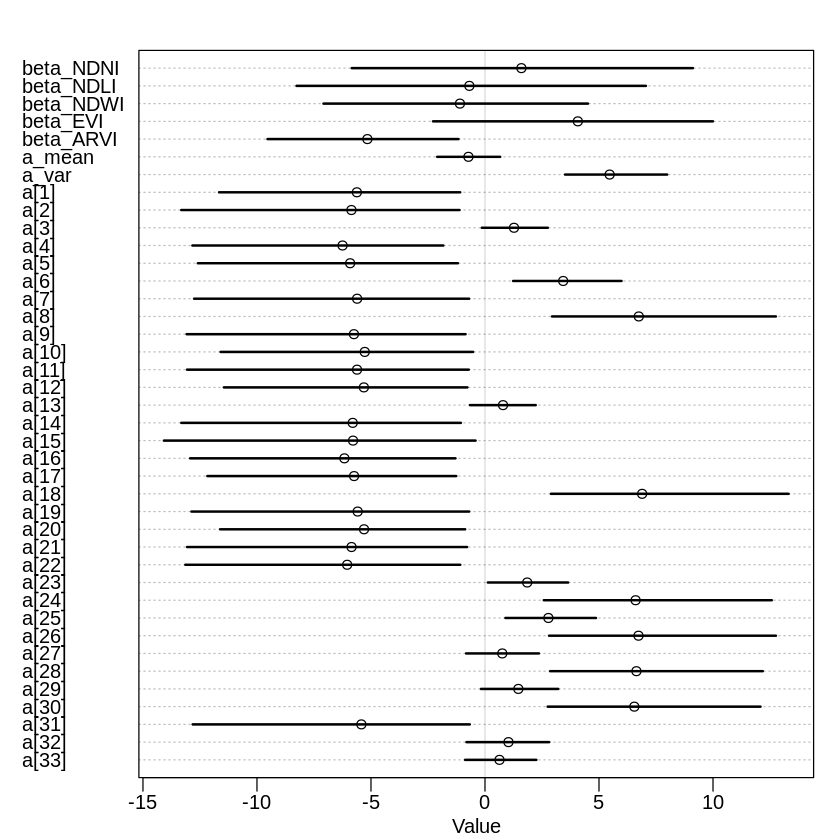

In [29]:
plot(precis(model_17_and_18,width=0.95,depth=2)) # also plot

## IV. future work
- causation vs. correlation of remote sensing indecies 
- how much temporal data would we need to forecast?
- propograting uncertainty from model fit to SDM
    - most GLM-based SDMs don't do this 